# ML model in pytorch:

## Setting up:
### Additional installations

In [1]:
! pip install cartopy
! pip install pyproj
! pip install wandb
! pip uninstall shapely
! pip install shapely --no-binary shapely

Found existing installation: Shapely 1.8.1.post1
Uninstalling Shapely-1.8.1.post1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Shapely-1.8.1.post1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/shapely/*
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.8.1.post1
  Using cached Shapely-1.8.1.post1.tar.gz (198 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.1.post1-cp37-cp37m-linux_x86_64.whl size=665622 sha256=83a8b66e9c377f4d05198d4bbd1fbdc9e472d7feed981a073e00ea3ccde27373
  Stored in directory: /root/.cache/pip/wheels/ea/8d/2f/ab748b8a432b3c6cd72e751b3bca17c5a9ed4538b1e78467e6
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, 

### Imports:

In [5]:
# Basics
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import os
import sys
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from re import search
from math import cos,sin,pi
import random as rn
from google.colab import auth

# xarray and cartopy plots
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import pyproj
from pyproj import Transformer

# ML
from scipy import ndimage
import torch
import tensorflow as tf 
import torch.nn as nn
import torch.nn.functional as F
import argparse
import logging
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split
#import setGPU

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up CUDA:

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device:0
Name of current CUDA device:Tesla P100-PCIE-16GB


### Helper scripts:

In [12]:
# Load configuration file:
from config import *
from helperFunctions import *

# Import custom scripts
sys.path.append('../')
from GC_scripts import * # Google cloud scripts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Google Cloud:

In [6]:
auth.authenticate_user()
# Give our project ID
project_id = 'ee-iceshelf-gee4geo'
!gcloud config set project {project_id}
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://ee-downscalingclimatemodels/test.txt /tmp/gsutil_download.txt
# Print the result to make sure the transfer worked.
!cat /tmp/gsutil_download.txt

Updated property [core/project].
Copying gs://ee-downscalingclimatemodels/test.txt...
/ [1 files][   13.0 B/   13.0 B]                                                
Operation completed over 1 objects/13.0 B.                                       
AIAIAIAIAIAIA

## Load data:

### (Input) Global climate model:

In [7]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)
print(GCMLike.dims)
GCMLike

Frozen(SortedKeysDict({'x': 90, 'y': 25, 'time': 1452}))


<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
    spatial_ref  int64 ...
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
Data variables:
    RF           (time, y, x) float32 ...
    SP           (time, y, x) float32 ...
    LWD          (time, y, x) float32 ...
    SWD          (time, y, x) float32 ...
    TT           (time, y, x) float32 ...
    SMB          (time, y, x) float32 ...
    VVP          (time, y, x) float64 ...
    UUP          (time, y, x) float64 ...
Attributes:
    crs:      3031

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated 

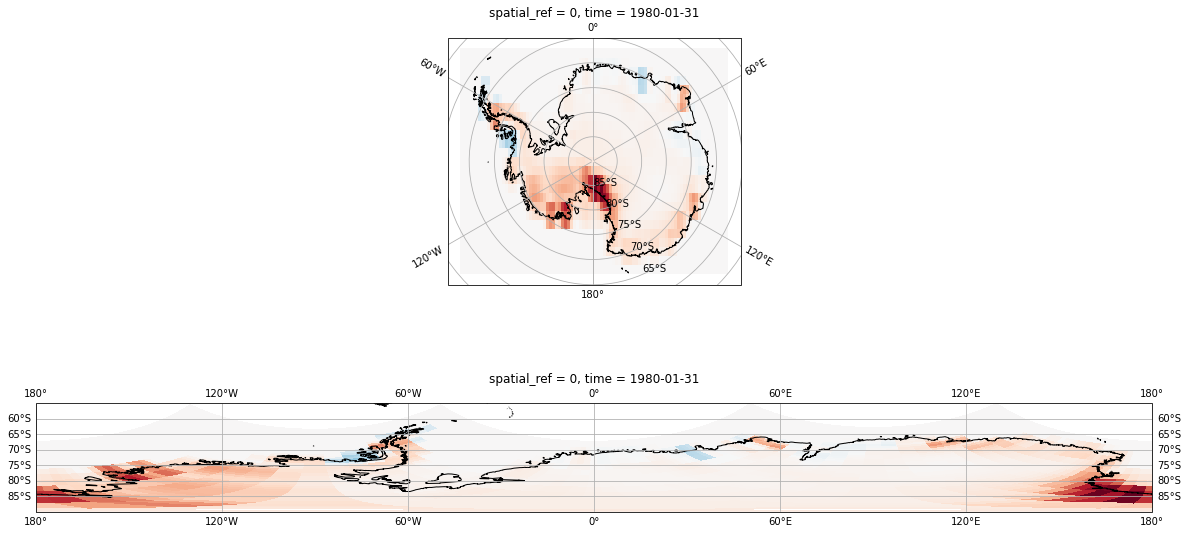

In [8]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1, projection=ccrs.SouthPolarStereo())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
GCMLike.SMB.isel(time=0).plot(
    x="x", ax=ax, transform=ccrs.SouthPolarStereo(), add_colorbar=False
)
ax.coastlines("10m", color="black")
ax.gridlines(draw_labels=True)

### (Target) Regional climate model:

In [9]:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileTarget)
    target_dataset = xr.open_dataset(fileTarget)
    os.remove(fileTarget)
else:
    target_dataset = xr.open_dataset(pathCluster + fileTarget)
print(target_dataset.dims)

# Cut a small part of on the right that is not too important
N = 160
max_x = (N / 2) * 35 * 1000
max_y = (N / 2) * 35 * 1000

target_dataset = cutBoundaries(target_dataset, max_x, max_y)
print("New target dimensions:", target_dataset.dims)

Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 176, 'PLEV': 7}))
New target dimensions: Frozen(SortedKeysDict({'time': 1452, 'y': 148, 'x': 160, 'PLEV': 7}))


## Input and target for model:

**Z**:
- (ignore for now) External forcing also given to RCM → total concentration of greenhouse gases and solar and ozone forcings
- Cosinus, sinus vector to encode information about day of year
- Daily spatial means and standard deviations time series for each $X_{i,j,m}$ (because normalising 2D variables removes temporal information)

**X**: 
SHAPE `[nbmonths, x, y, nb_vars]`

For pytorch need to put into `[nbmonths, nb_vars, x, y]`

### Input:

In [10]:
def input_maker(
    GCMLike,
    size_input_domain=16,  # size of domain, format: 8,16,32, must be defined in advance
    stand=True,  # standardization
    seas=True,  # put a cos, sin vector to control the season, format : bool
    means=True,  # add the mean of the variables raw or stdz, format : bool
    stds=True,  # add the std of the variables raw or stdz, format : bool
    resize_input=True,  # resize input to size_input_domain
    region="Larsen",  # region of interest
    print_=True,
):

    if region != "Whole Antarctica":
        DATASET = createLowerInput(GCMLike, region=region, Nx=48, Ny=25, print_=False)
    else:
        DATASET = GCMLike
    """
    MAKE THE 2D INPUT ARRAY
    SHAPE [nbmonths, x, y, nb_vars]
    """

    # Remove target variable from DATASET:
    DATASET = DATASET.drop(["SMB"])

    nbmonths = DATASET.dims["time"]
    x = DATASET.dims["x"]
    y = DATASET.dims["y"]
    nb_vars = len(list(DATASET.data_vars))
    VAR_LIST = list(DATASET.data_vars)

    INPUT_2D_bf = np.transpose(
        np.asarray([DATASET[i].values for i in VAR_LIST]), [1, 2, 3, 0]
    )

    # if no size is given, take smallest power of 2
    if size_input_domain == None:
        size_input_domain = np.max(
            [
                highestPowerof2(INPUT_2D_bf.shape[1]),
                highestPowerof2(INPUT_2D_bf.shape[2]),
            ]
        )

    if resize_input:
        # resize to size_input_domain
        INPUT_2D = resize(INPUT_2D_bf, size_input_domain, size_input_domain, print_)
    else:
        INPUT_2D = INPUT_2D_bf

    if stand:
        # Standardize:
        INPUT_2D_SDTZ = standardize(INPUT_2D)
        # in their code with aerosols extra stuff but ignore
        INPUT_2D_ARRAY = INPUT_2D_SDTZ
    else:
        INPUT_2D_ARRAY = INPUT_2D

    if print_:
        print("Parameters:\n -------------------")
        print("Size of input domain:", size_input_domain)
        print("Region:", region)
        print("\nCreating 2D input X:\n -------------------")
        print(f"Number of variables: {nb_vars}")
        print(f"Variables: {VAR_LIST}")
        print(f"INPUT_2D shape: {INPUT_2D_ARRAY.shape}")
        print("\nCreating 1D input Z:\n -------------------")

    """
    MAKE THE 1D INPUT ARRAY
    CONTAINS MEANS, STD SEASON IF ASKED
    """

    INPUT_1D = []
    if means and stds:
        vect_std = INPUT_2D.std(axis=(1, 2))
        vect_means = INPUT_2D.mean(axis=(1, 2))
        SpatialMean = vect_means.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])
        SpatialSTD = vect_std.reshape(INPUT_2D.shape[0], 1, 1, INPUT_2D.shape[3])

        INPUT_1D.append(SpatialMean)
        INPUT_1D.append(SpatialSTD)
        if print_:
            print(f"SpatialMean/std shape: {SpatialMean.shape}")

    if seas:
        months = 12
        cosvect = np.tile(
            [cos(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        sinvect = np.tile(
            [sin(2 * i * pi / months) for i in range(months)],
            int(INPUT_2D.shape[0] / months),
        )
        cosvect = cosvect.reshape(INPUT_2D.shape[0], 1, 1, 1)
        sinvect = sinvect.reshape(INPUT_2D.shape[0], 1, 1, 1)

        INPUT_1D.append(cosvect)
        INPUT_1D.append(sinvect)
        if print_:
            print(f"Cos/sin encoding shape: {cosvect.shape}")

    INPUT_1D_ARRAY = np.concatenate(INPUT_1D, axis=3)
    if print_:
        print(f"INPUT_1D shape: {INPUT_1D_ARRAY.shape}")

    DATASET.close()
    return INPUT_2D_ARRAY, INPUT_1D_ARRAY, VAR_LIST

In [11]:
def make_inputs(GCMLike, Size_input_domain, Region):
    # Make input
    i2D, i1D, VAR_LIST = input_maker(
        GCMLike=GCMLike,
        size_input_domain=Size_input_domain,
        stand=True,  # standardization
        seas=True,  # put a cos,sin vector to control the season, format : bool
        means=True,  # add the mean of the variables raw or stdz, format : r,s,n
        stds=True,
        resize_input=True,
        region=Region,
        print_=False,
    )

    # Make a non standardised version for plots:
    i2D_ns, i1D_ns, var_list = input_maker(
        GCMLike=GCMLike,
        size_input_domain=Size_input_domain,
        stand=False,  # standardization
        seas=True,  # put a cos,sin vector to control the season, format : bool
        means=True,  # add the mean of the variables raw or stdz, format : r,s,n
        stds=True,
        resize_input=False,
        region=Region,
        print_=False,
    )
    return i1D, i2D, i1D_ns, i2D_ns, VAR_LIST

In [14]:
# Download GMC like RCM input data:
if DOWNLOAD_FROM_GC:
    downloadFileFromGC(pathGC, "", fileGCMLike)
    GCMLike = xr.open_dataset(fileGCMLike)
    os.remove(fileGCMLike)
else:
    GCMLike = xr.open_dataset(pathCluster + fileGCMLike)

if REGION == "Combined":
    inputs_2D = []
    inputs_1D = []
    inputs_2D_ns = []
    inputs_1D_ns = []
    for r in REGIONS:
        i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
            GCMLike, SIZE_INPUT_DOMAIN, Region=r
        )
        inputs_1D.append(i1D)
        inputs_2D.append(i2D)
        inputs_1D_ns.append(i1D_ns)
        inputs_2D_ns.append(i2D_ns)
else:
    i1D, i2D, i1D_ns, i2D_ns, VAR_LIST = make_inputs(
        GCMLike, SIZE_INPUT_DOMAIN, Region=REGION
    )
    inputs_2D_ns = [i2D_ns]
    inputs_1D_ns = [i1D_ns]
    inputs_2D = [i2D]
    inputs_1D = [i1D]
    REGIONS = [REGION]

# Full input to model
full_input = [np.concatenate(inputs_2D, axis=0), np.concatenate(inputs_1D, axis=0)]
full_input_ns = [
    np.concatenate(inputs_2D_ns, axis=0),
    np.concatenate(inputs_1D_ns, axis=0),
]

### Target:

In [15]:
def target_maker(
    target_dataset,
    region="Larsen",  # region of interest
    resize=True,  # resize to target_size
    target_size=None,  # if none provided and resize true, set to min highest power of 2
):
    target_times = []
    targets = []

    if region != "Whole antarctica":
        lowerTarget = createLowerTarget(
            target_dataset, region=region, Nx=64, Ny=64, print_=False
        )
        targetArray = lowerTarget.SMB.values
    else:
        targetArray = target_dataset.SMB.values

    targetArray = targetArray.reshape(
        targetArray.shape[0], targetArray.shape[1], targetArray.shape[2], 1
    )

    if target_size == None:
        # resize to highest power of 2:
        target_size = np.min(
            [
                highestPowerof2(targetArray.shape[1]),
                highestPowerof2(targetArray.shape[2]),
            ]
        )

    if resize:
        target_SMB = resize(targetArray, target_size, target_size)
    else:
        target_SMB = targetArray

    targets.append(target_SMB)
    target_times.append(target_dataset.time.values)

    return targets, target_times

In [16]:
if REGION == "Combined":
    targets, target_times = [], []
    for r in REGIONS:
        t, t_times = target_maker(target_dataset, region=r, resize=False)
        targets.append(t[0])
        target_times.append(t_times[0])
else:
    targets, target_times = target_maker(target_dataset, region=REGION, resize=False)
# Full target to model
full_target = np.concatenate(targets, axis=0)
target_time = np.concatenate(target_times, axis=0)
target_lon = target_dataset["x"]
target_lat = target_dataset["y"]

In [17]:
print("Shapes of targets and inputs:\n---------------------------")
print("Target:", full_target.shape)
print("Input 2D:", full_input[0].shape)
print("Input 1D:", full_input[1].shape)

Shapes of targets and inputs:
---------------------------
Target: (5808, 64, 64, 1)
Input 2D: (5808, 32, 32, 7)
Input 1D: (5808, 1, 1, 16)


### Example of each region of Antarctica:
Plot an example of each region that is used.

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


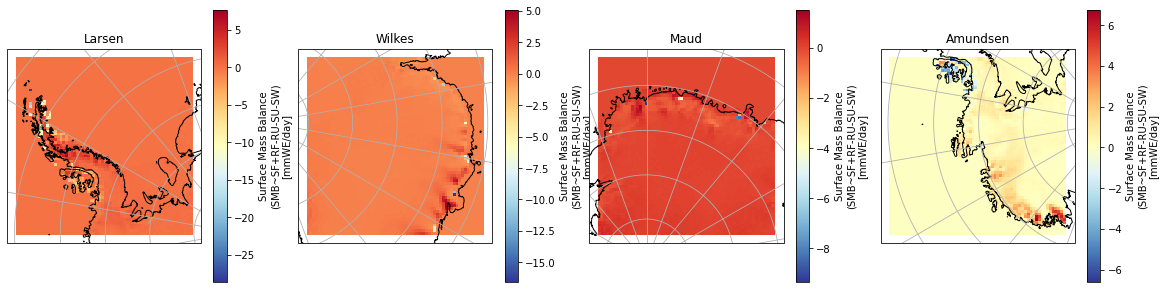

In [18]:
f = plt.figure(figsize=(20, 5))
i = 1
for r in REGIONS:
    targets, target_times = target_maker(target_dataset, region=r, resize=False)
    full_target_test = np.concatenate(targets, axis=0)[0, :, :, :]
    ax = plt.subplot(1, 4, i, projection=ccrs.SouthPolarStereo())
    vmin = np.min(full_target_test)
    vmax = np.max(full_target_test)
    plotTarget(target_dataset, full_target_test, ax, vmin, vmax, region=r)
    ax.set_title(r)
    i += 1

### Create pytorch tensors:

In [19]:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))
X.shape, Z.shape, Y.shape

(torch.Size([5808, 7, 32, 32]),
 torch.Size([5808, 16, 1, 1]),
 torch.Size([5808, 1, 64, 64]))

Create encoding of regions so that each sample has a number that indicates which region of Antarctica it corresponds to.

In [21]:
# Indicator of regions and their order if combined dataset
# Encoding 0-> Num regions
regions = []
if REGION == "Combined":
    N = int(len(X) / len(REGIONS))
    for j in range(len(REGIONS)):
        for i in range(N):
            regions.append(j)
else:
    N = len(X)
    regions = [0 for i in range(N)]
print(len(regions))
R = torch.tensor(regions) # Change to tensor

5808


## Create dataset:
Show an example of process of how dataset is created.

In [26]:
# 1. Create dataset
dataset = TensorDataset(X, Z, Y, R)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Example:
(x, z, y, r) = next(iter(loader))
print(f"2D Feature batch shape: {x.size()}")
print(f"1D Feature batch shape: {z.size()}")
print(f"Labels batch shape: {y.size()}")

# 2. Split into train / validation partitions
n_val = int(len(dataset) * VAL_PERCENT)
n_train = len(dataset) - n_val
train_set, val_set = random_split(
    dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
)

# 3. Create data loaders
loader_args = dict(batch_size=BATCH_SIZE)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE)

2D Feature batch shape: torch.Size([32, 7, 32, 32])
1D Feature batch shape: torch.Size([32, 16, 1, 1])
Labels batch shape: torch.Size([32, 1, 64, 64])


### Examples of input to model:

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:385: ShapelyDeprecationWarning: Iteration over multi-pa

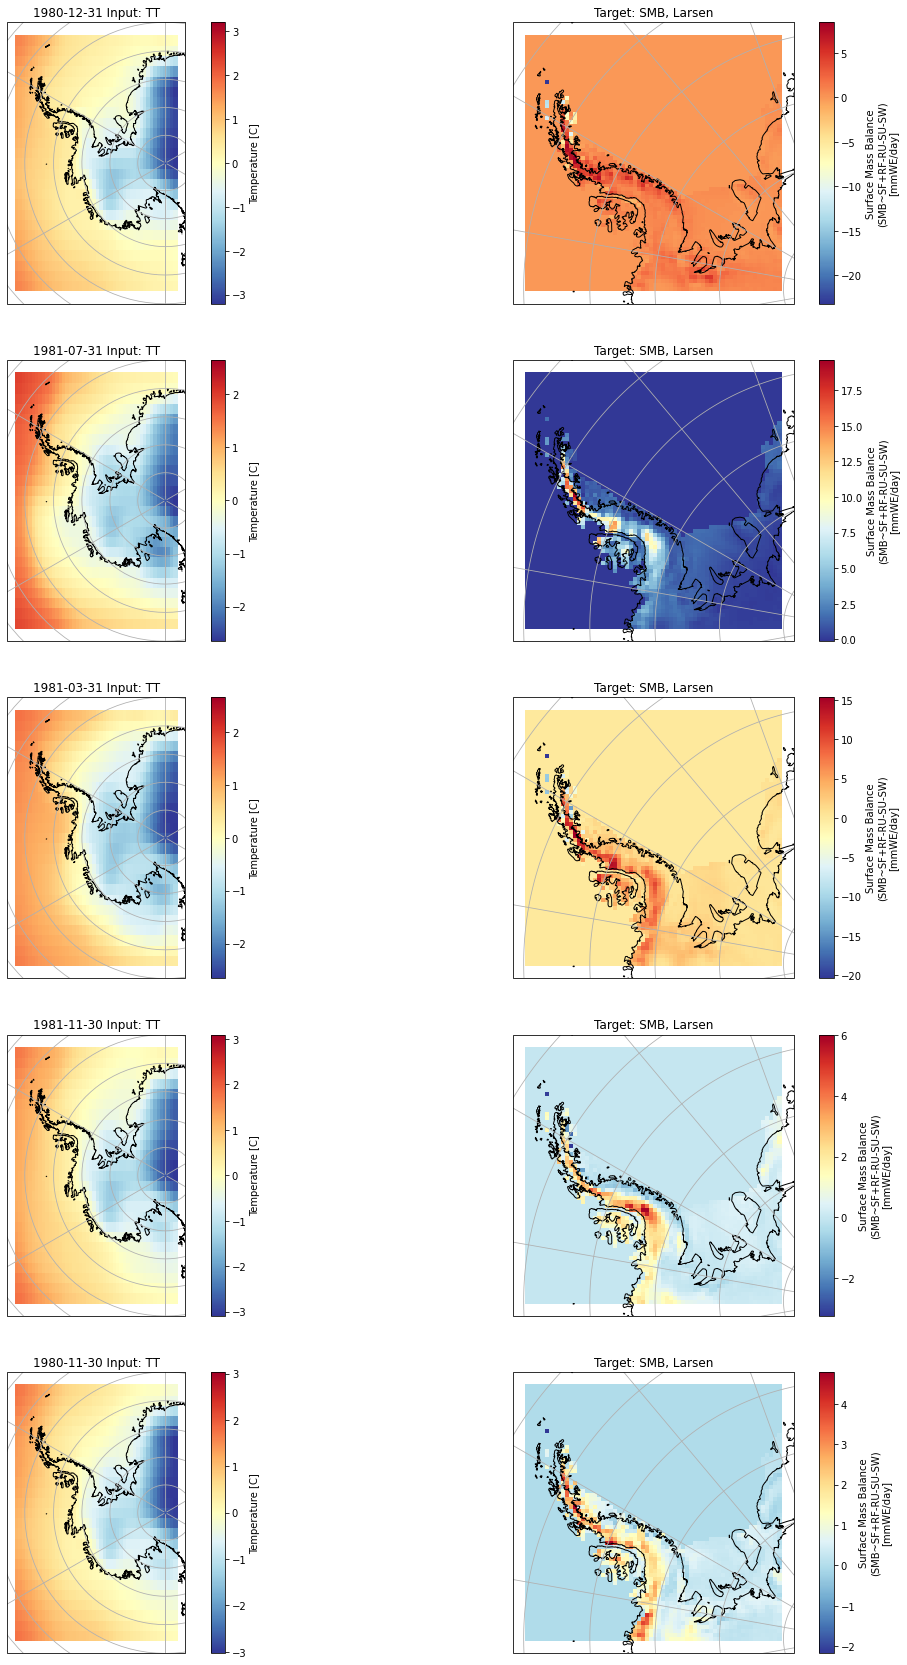

In [30]:
# 4. Display input and targets.
N = 5 
f = plt.figure(figsize=(20, 30))

for i in range(N):
  train_X, train_Z, train_Y, train_R = next(iter(loader))
  randTime = rn.randint(0, len(train_X)-1)
  sample2dtrain_ = train_X.numpy().transpose(0, 2, 3, 1)[randTime]
  sampletarget_ = train_Y.numpy().transpose(0, 2, 3, 1)[randTime]
  sampleregion = train_R[randTime]
  dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
  time = str(dt.date[0])

  if REGION != "Whole Antarctica":
      sample2dtrain_ = resize(sample2dtrain_, 25, 48, print_=False)
  else:
      sample2dtrain_ = resize(sample2dtrain_, 25, 90, print_=False)
  vmin = np.min(sampletarget_)
  vmax = np.max(sampletarget_)

  M = 2
  for m in range(M):
    if m == 0:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTrain(GCMLike, sample2dtrain_, 4, ax, time, VAR_LIST, region=REGIONS[sampleregion])
    if m == 1:
      ax = plt.subplot(N, 2, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
      plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=REGIONS[sampleregion])

## U-Net:

### Architecture:

In [31]:
# import architecture from py files
from unet import *

In [32]:
# Test of U-Net:
n_channels_x = 7
n_channels_z = 16
size = 32
filter = 64

unet = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

train_X, train_Z, train_Y, train_R = next(iter(train_loader))
x = unet(train_X, train_Z)
x.shape, train_X.shape, train_Z.shape, train_R.shape

(torch.Size([32, 1, 64, 64]),
 torch.Size([32, 7, 32, 32]),
 torch.Size([32, 16, 1, 1]),
 torch.Size([32]))

## Training

In [33]:
# Load configuration file:
from config import *
from helperFunctions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Training function:

In [35]:
def train_net(
    net,
    dataset,
    device,
    epochs: int = 5,
    batch_size: int = 1,
    learning_rate: float = 1e-5,
    val_percent: float = 0.1,
    save_checkpoint: bool = True,
    amp: bool = False,
):
    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(
        dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED)
    )
    logging.info(f"Train set size: {n_val}\n" f"Validation set size: {n_train}\n")
    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project="U-Net", resume="allow", anonymous="must")
    experiment.config.update(
        dict(
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            val_percent=val_percent,
            save_checkpoint=save_checkpoint,
            amp=amp,
        )
    )
    logging.info(
        f"""Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Mixed Precision: {amp}
    """
    )

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=4, verbose=1
    )  # goal: minimize loss
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.MSELoss()
    global_step = 0

    # 5. Begin training
    train_loss_e = []
    val_loss_e = []
    for epoch in range(1, epochs + 1):
        net.train()
        epoch_loss = 0
        with tqdm(
            total=n_train, desc=f"Epoch {epoch}/{epochs}", unit="timestep"
        ) as pbar:
            train_loss = 0
            val_loss = 0
            for batch in train_loader:
                X_train, Z_train, Y_train, R_train = (
                    batch[0],
                    batch[1],
                    batch[2],
                    batch[3],
                )
                X_train_cuda = X_train.to(device=device, dtype=torch.float32)
                Z_train_cuda = Z_train.to(device=device, dtype=torch.float32)
                true_smb = Y_train.to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp):
                    smb_pred = net(X_train_cuda, Z_train_cuda)
                    loss = criterion(smb_pred, true_smb)

                    train_loss += loss.item()  # for plots

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(X_train.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log(
                    {"train loss": loss.item(), "step": global_step, "epoch": epoch}
                )
                pbar.set_postfix(**{"loss (batch)": loss.item()})

                # Evaluation round
                division_step = n_train // (10 * batch_size)
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        val_score = evaluate(net, val_loader, device, criterion)
                        val_loss += val_score.item()
                        scheduler.step(val_score)

                        # logging.info('Validation MSE loss: {}'.format(val_score))
                        experiment.log(
                            {
                                "learning rate": optimizer.param_groups[0]["lr"],
                                "validation mse": val_score,
                                "images": wandb.Image(X_train_cuda[0, 0, :, :].cpu()),
                                "masks": {
                                    "true": wandb.Image(true_smb[0].cpu()),
                                    "pred": wandb.Image(smb_pred[0].cpu()),
                                },
                                "step": global_step,
                                "epoch": epoch,
                                **histograms,
                            }
                        )

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(
                net.state_dict(),
                str(dir_checkpoint / "checkpoint_epoch{}.pth".format(epoch)),
            )
            logging.info(f"Checkpoint {epoch} saved!")

        train_loss_e.append(
            train_loss / len(train_loader)
        )  # return train loss divided by num batches
        val_loss_e.append(val_loss / len(val_loader))
    # Save final model:
    Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
    torch.save(
        net.state_dict(),
        str(dir_checkpoint / f"MODEL_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth"),
    )

    return train_loss_e, val_loss_e

### Evaluate function:

In [36]:
def evaluate(net, dataloader, device, criterion):
    net.eval()
    num_val_batches = len(dataloader)
    mse_loss = 0

    # iterate over the validation set
    # for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
    for batch in dataloader:
        X_val, Z_val, Y_val, R_val = batch[0], batch[1], batch[2], batch[3]
        # move images and labels to correct device and type
        X_val_cuda = X_val.to(device=device, dtype=torch.float32)
        Z_val_cuda = Z_val.to(device=device, dtype=torch.float32)
        true_smb = Y_val.to(device=device, dtype=torch.float32)

        with torch.no_grad():
            # predict the mask
            smb_pred = net(X_val_cuda, Z_val_cuda)
            mse_loss += criterion(smb_pred, true_smb)
    net.train()
    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return mse_loss
    return mse_loss / num_val_batches

### Train model:

In [ ]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device {device}")

n_channels_x = 7
n_channels_z = 16
size = 32
filter = 64
load = False  # type=str, default=False, Load model from a .pth file

dir_checkpoint = Path("./checkpoints/")

net = UNetMarijn(
    n_channels_x=n_channels_x,
    n_channels_z=n_channels_z,
    size=size,
    filter=filter,
    bilinear=False,
)

logging.info(
    f"Network:\n"
    f"\t{net.n_channels_x} input channels X\n"
    f"\t{net.n_channels_z} input channels Z\n"
    f"\t{net.size} size\n"
    f"\t{net.filter} filter\n"
    f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling'
)


if load:  # Load model from a .pth file
    net.load_state_dict(torch.load(load, map_location=device))
    logging.info(f"Model loaded from {load}")

net.to(device=device)

# 1. Create dataset:
X = torch.tensor(full_input[0].transpose(0, 3, 1, 2))
Z = torch.tensor(full_input[1].transpose(0, 3, 1, 2))
Y = torch.tensor(full_target.transpose(0, 3, 1, 2))

# Indicator of regions and their order if combined dataset
# Encoding 0-> Num regions
regions = []
if REGION == "Combined":
    N = int(len(X) / len(REGIONS))
    for j in range(len(REGIONS)):
        for i in range(N):
            regions.append(j)
else:
    N = len(X)
    regions = [0 for i in range(N)]
R = torch.tensor(regions)  # Change to tensor

dataset = TensorDataset(X, Z, Y, R)

# 2. Split into test and train/val set:
n_test = int(len(dataset) * TEST_PERCENT)
n_train = len(dataset) - n_test
logging.info(f"Test set size: {n_test}\n" f"Train set size: {n_train}\n")
train_set, test_set = random_split(
    dataset, [n_train, n_test], generator=torch.Generator().manual_seed(SEED)
)

try:
    train_loss_e, val_loss_e = train_net(
        net=net,
        dataset=train_set,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LR,
        device=device,
        val_percent=VAL_PERCENT,
        amp=AMP,
    )

except KeyboardInterrupt:
    torch.save(net.state_dict(), "INTERRUPTED.pth")
    logging.info("Saved interrupt")

INFO: Using device cuda
INFO: Network:
	7 input channels X
	16 input channels Z
	32 size
	64 filter
	Transposed conv upscaling
INFO: Test set size: 580
Train set size: 5228

INFO: Train set size: 1045
Validation set size: 4183

wandb: Currently logged in as: anony-mouse-247331 (use `wandb login --relogin` to force relogin)


INFO: Starting training:
        Epochs:          100
        Batch size:      32
        Learning rate:   0.005
        Training size:   4183
        Validation size: 1045
        Checkpoints:     True
        Device:          cuda
        Mixed Precision: False
    
Epoch 1/100: 100%|██████████| 4183/4183 [00:26<00:00, 158.40timestep/s, loss (batch)=0.944]
INFO: Checkpoint 1 saved!
Epoch 2/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.75timestep/s, loss (batch)=0.99]
INFO: Checkpoint 2 saved!
Epoch 3/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.88timestep/s, loss (batch)=1.08]
INFO: Checkpoint 3 saved!
Epoch 4/100: 100%|██████████| 4183/4183 [00:25<00:00, 163.79timestep/s, loss (batch)=0.521]
INFO: Checkpoint 4 saved!
Epoch 5/100: 100%|██████████| 4183/4183 [00:25<00:00, 163.19timestep/s, loss (batch)=0.77]
INFO: Checkpoint 5 saved!
Epoch 6/100:  97%|█████████▋| 4064/4183 [00:25<00:01, 108.75timestep/s, loss (batch)=0.736]

Epoch 00060: reducing learning rate of group 0 to 5.0000e-04.


Epoch 6/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.73timestep/s, loss (batch)=0.806]
INFO: Checkpoint 6 saved!
Epoch 7/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.42timestep/s, loss (batch)=0.711]
INFO: Checkpoint 7 saved!
Epoch 8/100:   5%|▌         | 224/4183 [00:02<00:52, 75.62timestep/s, loss (batch)=0.771]

Epoch 00071: reducing learning rate of group 0 to 5.0000e-05.


Epoch 8/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.63timestep/s, loss (batch)=0.979]
INFO: Checkpoint 8 saved!
Epoch 9/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.54timestep/s, loss (batch)=0.478]
INFO: Checkpoint 9 saved!
Epoch 10/100:  44%|████▎     | 1824/4183 [00:12<00:25, 93.84timestep/s, loss (batch)=0.735]

Epoch 00095: reducing learning rate of group 0 to 5.0000e-06.


Epoch 10/100: 100%|██████████| 4183/4183 [00:25<00:00, 162.16timestep/s, loss (batch)=0.55]
INFO: Checkpoint 10 saved!
Epoch 11/100:   4%|▍         | 160/4183 [00:01<00:52, 76.19timestep/s, loss (batch)=0.601]

Epoch 00101: reducing learning rate of group 0 to 5.0000e-07.


Epoch 11/100:  11%|█▏        | 480/4183 [00:03<00:14, 259.41timestep/s, loss (batch)=0.758]

### Plot losses:

In [ ]:
plt.plot(train_loss_e)

In [ ]:
plt.plot(val_loss_e)

## Prediction:

### Prediction function:

In [ ]:
def predict(net, device, test_loader, model):
    logging.info(f"Loading saved model {model}")
    logging.info(f"Using device {device}")

    net.to(device=device)
    net.load_state_dict(torch.load(str(dir_checkpoint / model), map_location=device))
    logging.info("Saved model loaded!")

    preds = []
    x = []
    z = []
    y = []
    r = []

    for batch in tqdm(
        test_loader,
        total=len(test_loader),
        desc="Testing round",
        unit="batch",
        leave=False,
    ):
        X_test, Z_test, Y_test, R_test = batch[0], batch[1], batch[2], batch[3]
        X_test_cuda = X_test.to(device=device, dtype=torch.float32)
        Z_test_cuda = Z_test.to(device=device, dtype=torch.float32)
        true_smb = Y_test.to(device=device, dtype=torch.float32)

        net.eval()
        prediction = net(X_test_cuda, Z_test_cuda)
        prediction = prediction.cpu().detach().numpy()
        preds.append(prediction.transpose(0, 2, 3, 1)[0])  # change to numpy
        x.append(X_test.numpy().transpose(0, 2, 3, 1)[0])
        z.append(Z_test.numpy().transpose(0, 2, 3, 1)[0])
        y.append(Y_test.numpy().transpose(0, 2, 3, 1)[0])
        r.append(R_test.numpy()[0])

    return preds, x, z, y, r

### Create test loader:

In [ ]:
loader_args = dict(batch_size=1, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=True, **loader_args)
model = f'MODEL_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

preds, x, z, true_smb, r = predict(net, device, test_loader, model)

### Plot predictions:

In [ ]:
from datetime import date

def plotRandomPredictions(preds, x, z, true_smb, r):
  today = str(date.today())

  f = plt.figure(figsize=(20, 30))
  map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)

  N = 5
  for i in range(N):
      randTime = rn.randint(0, len(preds)-1)
      sample2dtest_, sample_z, sampletarget_, samplepred_  = x[randTime], z[randTime], true_smb[randTime], preds[randTime]
      region = REGIONS[r[randTime]] # region of sample
      dt = pd.to_datetime([GCMLike.time.isel(time=randTime).values])
      time = str(dt.date[0])

      if region != "Whole Antarctica":
          sample2dtest_ = resize(sample2dtest_, 25, 48, print_=False)
      else:
          sample2dtest_ = resize(sample2dtest_, 25, 90, print_=False)

      vmin = np.min([sampletarget_, samplepred_])
      vmax = np.max([sampletarget_, samplepred_])

      M = 3
      for m in range(M):
          if m == 0:
              ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
              plotTrain(GCMLike, sample2dtest_, 4, ax, time, VAR_LIST, region=region)
          if m == 1:
              ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
              plotTarget(target_dataset, sampletarget_, ax, vmin, vmax, region=region)
          if m == 2:
              ax = plt.subplot(N, M, (i * M) + m + 1, projection=ccrs.SouthPolarStereo())
              plotPred(target_dataset, samplepred_, ax, vmin, vmax, region=region)
              
  plt.savefig(f'{today}_test_{REGION}_{NUM_EPOCHS}_{BATCH_SIZE}.png')

In [ ]:
plotRandomPredictions(preds, x, z, true_smb, r)